In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, cross_val_score
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings("ignore")

#%matplotlib notebook
%matplotlib widget

plt.style.use('ggplot')

# TP n°2 : Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

We know the optimization problem given by $$(w^*,w_0^*,\xi^* \in \mathbb{R}^n) \in arg min(\dfrac{1}{2}\|w\|^2 + C\Sigma_{i=1}^n\xi_i)$$ with the constraints $$\xi_i \geq 0$$ and 
$$y_i ((w,\Phi(x_i))+w_0)\geq1-\xi_i$$
which can be rewritten as :
$$\xi_i \geq 1-y_i ((w,\Phi(x_i))+w_0$$
and thus, because $\xi_i$ is greater than this quantity, we can put it back again in the primal problem expression as we are looking to minimize it anyways :
$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

Basically both function minimizing the lagrangian are convex : the $\|w\|^2$ part is strictly convex and the sum part is affine, thus convex as well. We have the expression in all points, are we are adjusting the parameters so that the overall result of the sum of both convex functions gets lower. As a convex upper bound going lower and lower. The hinge function is convex (it's a downwards slope that ends up being just a straight horizontal line) as well.
</br>
Regarding the pivotal loss, it will "convexify" the loss of binary classification, which means we will have triangles instead of the simple rectangles of standard binary classification.

## Example of using SVC (originally in ```svm_script.py```)

In [3]:
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
# text.usetex is set as False by default to avoid problems with student computers
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=[color_blind_list[i]], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

Score : 0.95


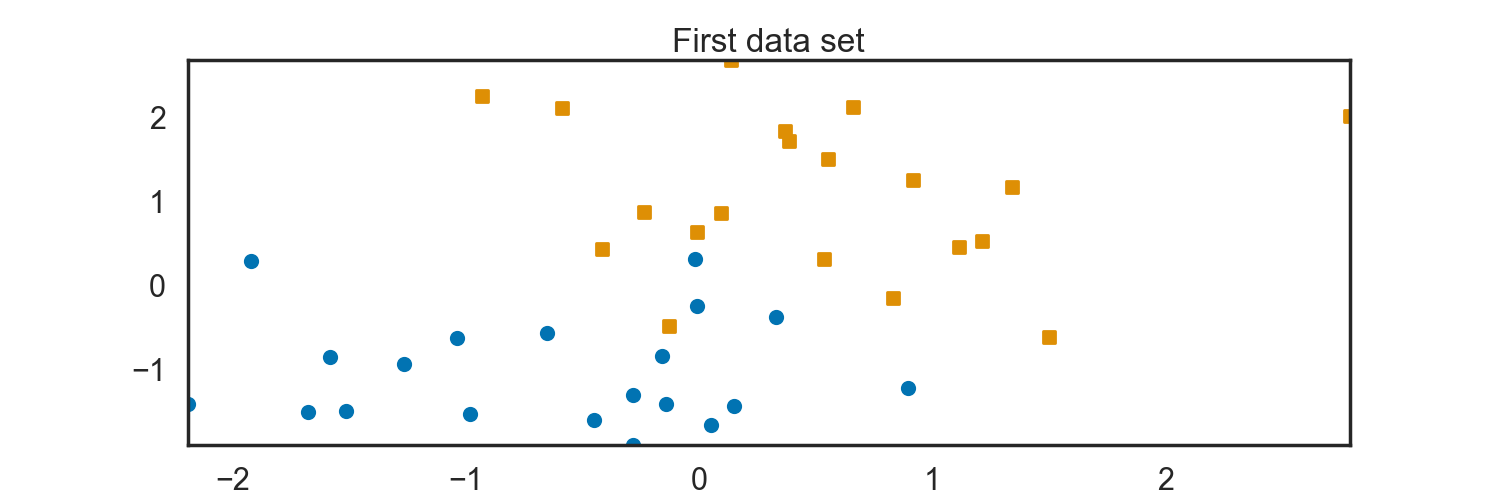

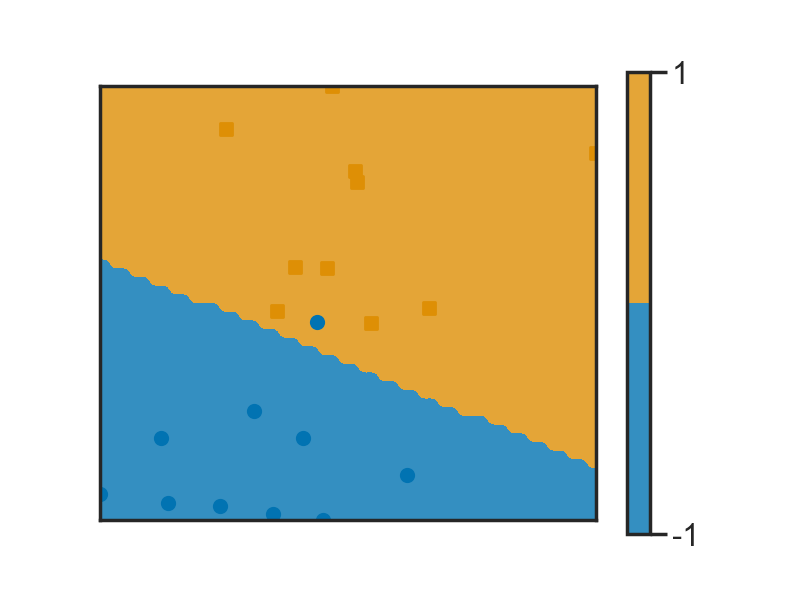

In [29]:
# This is an example of using SVC for data generated in the same way as the previous TP
plt.close('all')
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.title('First data set')
plot_2d(X1, y1)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score = clf.score(X_test, Y_test)
print('Score : %s' % score)
# display the frontiere


def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clf.predict(xx.reshape(1, -1))

plt.figure(2)
frontiere(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function make_blobs available in sklearn.datasets library. Reserve 75% of the data for training and 25% for the test data.

In [30]:
X, y, centers = make_blobs(n_samples=100, centers=2, n_features=2, return_centers = True)
#I take 100 samples from two 2-Dimensional gaussians, we fetch centers and std = 1.0

y = 2*y - 1 #To have {-1,+1} labels instead of {0,+1}
centers

array([[ 1.24721616, -4.20985235],
       [ 9.42846581,  8.06224123]])

In [31]:
X[0:5]

array([[ 9.74557017,  8.48193197],
       [ 1.46282301, -3.8323138 ],
       [ 1.51428871, -5.03676064],
       [ 0.64825145, -5.16129398],
       [ 9.37103652,  7.40420922]])

In [32]:
y

array([ 1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1,  1,
        1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1, -1,  1,  1,
        1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1, -1,
        1, -1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1, -1, -1,  1, -1,  1,
        1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1, -1,
       -1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1, -1, -1])

In [33]:
mean1, mean2 = centers[0],centers[1]
cov1, cov2 = 1.0,1.0

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**4)** Since the probability distributions are known, numerically estimate the Bayes risk.

In [35]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)

def eta(x):
    f_1      = multivariate_normal.pdf(x, mean=mean2, cov=cov1)
    f_minus1 = multivariate_normal.pdf(x, mean=mean1, cov=cov2)
    return f_1/(f_minus1 + f_1)

In [36]:
def bayesRisk(samples): #Labels aren't in the parameters, they're already in the eta function
    tmp, N = 0, len(samples)
    for i in range(N):
        etai = eta(samples[i])
        tmp += min(etai, 1-etai)
    return tmp/N

In [37]:
bayesRisk(X)

4.7327898555267886e-35

The bayes risk loss is very small, as expected, as it is the theoretical best classifier. The formula is given by 
$$R_B = \mathop{\mathbb{E}}[min(\eta(X), 1-\eta(X))]$$
with $\eta(x) = \mathop{\mathbb{P}}(Y=1|X=x)$
The Monte-Carlo method consists in applying the Strong Law of Large Numbers in the expectancy computation : $$\mathop{\mathbb{E}}[g(X)] \approx \dfrac{1}{n} \sum_{i=1}^{n}g(x_i),$$ with the $x_i$'s $i.i.d.$
In our particular case, we have 
$$\eta(x) = \mathop{\mathbb{P}}(Y=1|X=x) = \dfrac{\mathop{\mathbb{P}}(X=x|Y=1)\mathop{\mathbb{P}}(Y=1)}{\mathop{\mathbb{P}}(X=x|Y=1)\mathop{\mathbb{P}}(Y=1)+\mathop{\mathbb{P}}(X=x|Y=-1)\mathop{\mathbb{P}}(Y=-1)} = \dfrac{f_1(x)}{f_1(x) + f_{-1}(x)}$$

**5)** Draw the decision boundary H induced by SVM as well as the hyperplanes H1 and H−1. Vary the parameter C to see its impact on the number of support vectors. We can use the example https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

I will start with $C = 10$ and literally copy paste the box below for different values.

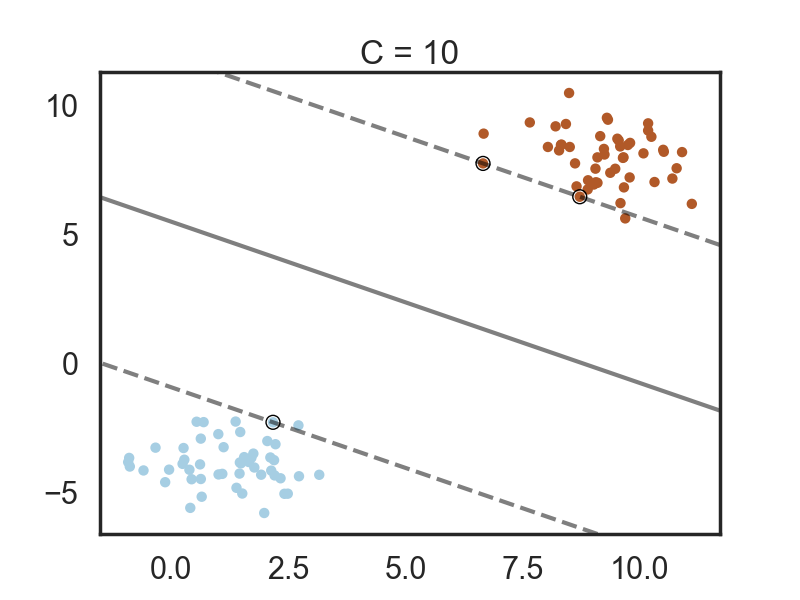

In [41]:
plt.close('all')
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=10)
clf.fit(X_train, y_train)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.title('C = 10')
plt.show()

We're gonna reduce $C$ a lot in order to observe variations, because the problem seems a little bit too easy for the classifier (it is actually, and later on we'll take a more difficult problem to "induce" errors), and with C higher than 1 we observe the same type of graph, the same pattern everytime. Below you will find graphs for $$C = {[1,~0.01,~0.005,~0.001]}$$

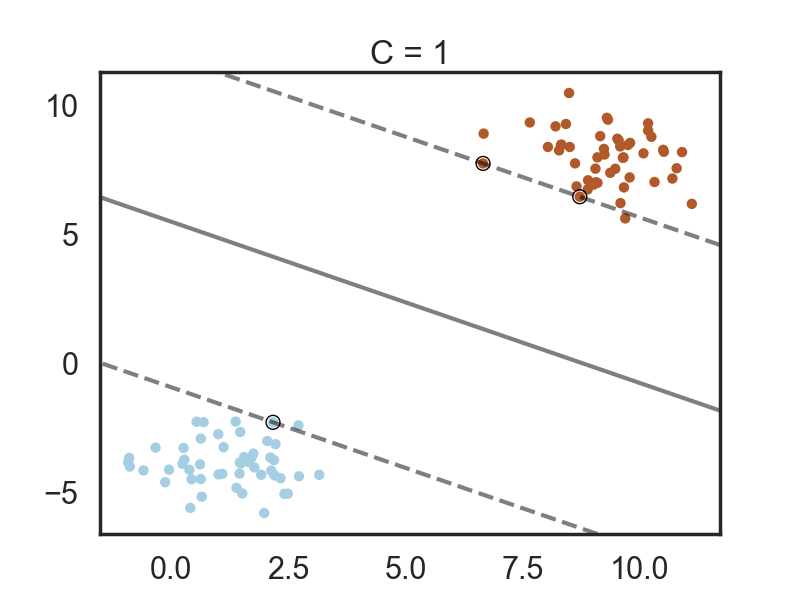

In [43]:
plt.close('all')
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=1)
clf.fit(X_train, y_train)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.title('C = 1')
plt.show()

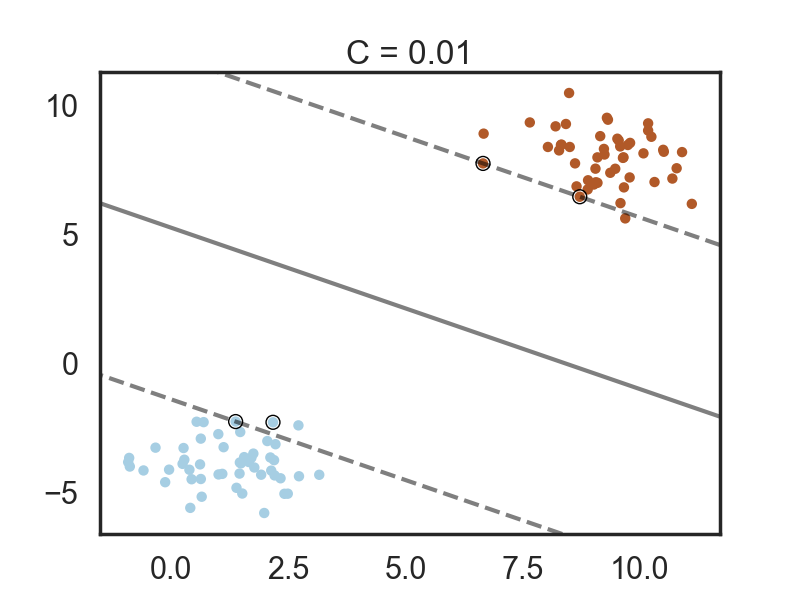

In [44]:
plt.close('all')
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=0.01)
clf.fit(X_train, y_train)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.title('C = 0.01')
plt.show()

Some points are on the wrong sides of the margins, ending up being more-than-support vectors in the middle, but no classification error has been made yet, only margin ones. 

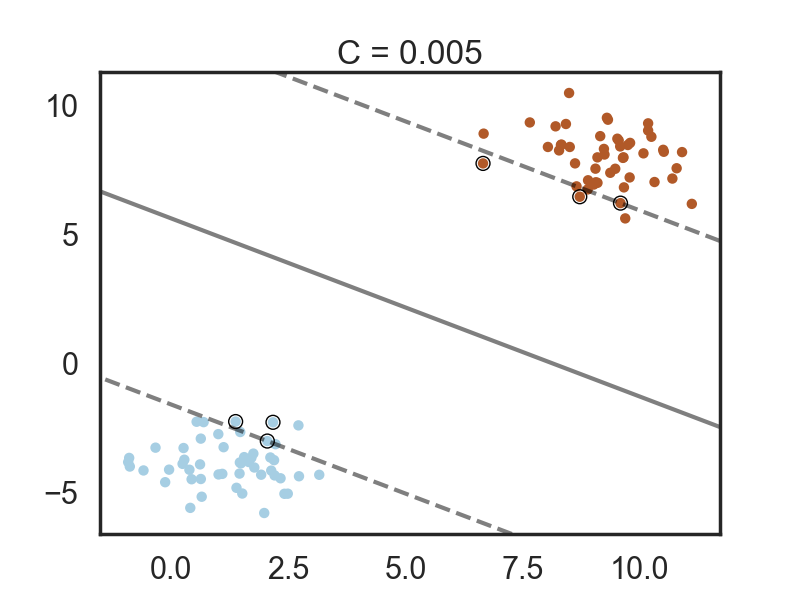

In [45]:
plt.close('all')
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=0.005)
clf.fit(X_train, y_train)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.title('C = 0.005')
plt.show()

Same but with more points ;

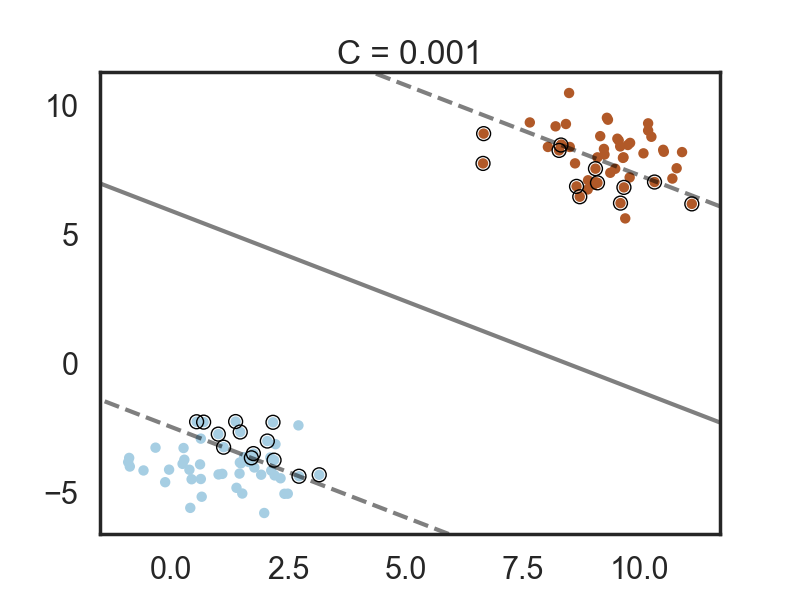

In [46]:
plt.close('all')
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=0.001)
clf.fit(X_train, y_train)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.title('C = 0.001')
plt.show()

Most points are out, that is, inside the two margins. Complexity has gotten so low that even for a problem this simple a lot of vectors remain not treated. 

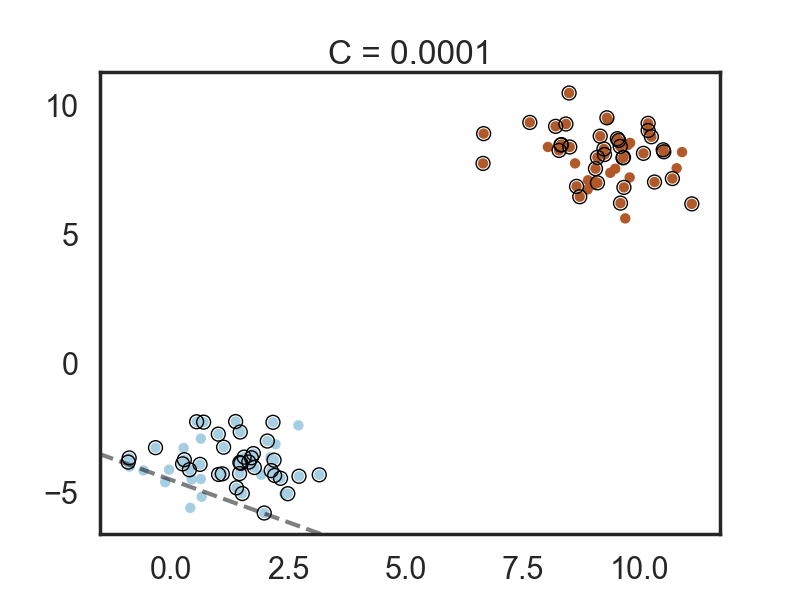

In [47]:
plt.close('all')
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel="linear", C=0.0001)
clf.fit(X_train, y_train)

plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(
    XX, YY, Z, colors="k", levels=[-1, 0, 1], alpha=0.5, linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(
    clf.support_vectors_[:, 0],
    clf.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="k",
)
plt.title('C = 0.0001')
plt.show()

As you can see, at the end we don't even classify anything anymore. </br>
# To sum everything up : 
The classification gets worse with C going down (it's the complexity, so no surprise there). With C = 0.01 we are at the beginning of the problems, with some vectors ending up in the middle, (or, if we put ourselves in the "right order" point of view, almost at the end of the research of the correct hyperplanes), with just the most extreme points being support vectors. With C = 0.001 we have all vectors that are support vectors. We are at the beginning, step 0. The complexity is extra low. 

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation to find the optimal parameter C∗ to classify this new dataset using a linear kernel.

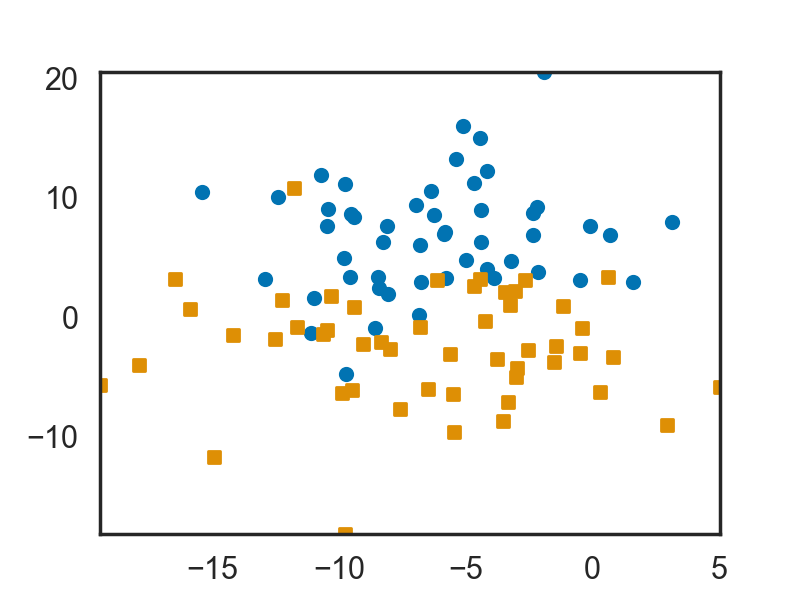

In [55]:
# Generate data and verify graphically that the two classes overlap
X, y, centers = make_blobs(n_samples=100, centers=2, n_features=2, cluster_std = 5, return_centers = True)
#I take 100 samples from two 2-Dimensional gaussians, we fetch centers, but this time we take the std to be very high so the classes overlap. 

y = 2*y - 1 #To have {-1,+1} labels instead of {0,+1}
plt.close('all')
plot_2d(X,y)
plt.show()

In [56]:
# Find the best working C with a 5-fold cross-validation
Clist = np.logspace(-5,3,30) #I found this list after a few tries. It is a log-spaced list with [10**(-5) ; 10] for boundaries. I kept the lowest C with the highest results.
bestaverage,newC=0,0
for C in Clist:
    clf = svm.SVC(kernel='linear', C=C, random_state=0)
    scores = cross_val_score(clf, X, y, cv=5)
    meanscores = np.mean(scores)
    if meanscores>bestaverage:
        bestaverage = meanscores
        newC = C
bestaverage

0.85

In [57]:
newC

0.0002395026619987486

The first thing to notice is that we reach the optimal C quite early, with a 0.85 score with $C^*=2.4*10^{-4}$, which means that even if the problem isn't as easy as before, the best solution the algorithm found was reached quite fast, meaning that even with more complexity, with a linear kernel, we couldn't do much more. </br>
The second thing to notice is that this $C^*$ value isn't equal to 1. Indeed, it's because the two distributions overlap, so with a linear classifier it is impossible to get a perfect classification. Instead, we get a 0.85 meaning some points still remain on the wrong side (that was expected of course, there's overlap for this reason). </br>
Still, I found that the results were not very diverse, "pas très variés" in french. This can be seen in the outputs of the cross_val_score function which gives 5-score arrays with the same values a lot of the time. Which averages again to values that are often the same, please see below : 

In [61]:
# I show here that the scores list being kind of the same for every C after any iteration.
bestaverage,newC=0,0
scoresL = []
for C in Clist:
    clf = svm.SVC(kernel='linear', C=C, random_state=42)
    scores = cross_val_score(clf, X, y, cv=5)
    scoresL.append(scores)
    meanscores = np.mean(scores)
    if meanscores>bestaverage:
        bestaverage = meanscores
        newC = C
scoresL[15:25]

[array([0.8 , 1.  , 0.85, 0.75, 0.85]),
 array([0.8 , 1.  , 0.85, 0.75, 0.85]),
 array([0.8 , 1.  , 0.85, 0.75, 0.85]),
 array([0.8 , 1.  , 0.85, 0.75, 0.85]),
 array([0.8 , 1.  , 0.85, 0.75, 0.85]),
 array([0.8 , 1.  , 0.85, 0.75, 0.85]),
 array([0.8 , 1.  , 0.85, 0.75, 0.85]),
 array([0.8 , 1.  , 0.85, 0.75, 0.85]),
 array([0.8 , 1.  , 0.85, 0.75, 0.85]),
 array([0.8 , 1.  , 0.85, 0.75, 0.85])]

Over a large set of C values (for linspace 100 values it's already long, so I didn't go further), I find the best average score to be 0.85 every time and a specific C around 0.00024. But these score values aren't very different from each other, as you can see they are only 0.05-seperated values for each fold. This array also shows clearly how the overlap introduced problems in the cross-validation. Some point sets are overlapping so much we have 0.75, or 0.8 scores, which is lower than the 0.85 we got overall.

**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore gamma and C), can lead to overfitting.

In [62]:
#I will first fit the SVM hyperparameters on the data, and then show how they do on the remaining test data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=8)

In [63]:
# Vary the parameter of the kernel and check the difference between training and testing scores
gammaList = np.logspace(-5,3,20)
Clist = np.logspace(-5,3,30) #Less C values because we also have gammas so it would take too long to compute. 
bestaverage = 0
bestGamma,bestC=0,0
scoresL = []
for C in Clist:
    for gamma in gammaList:
        clf = svm.SVC(kernel='rbf', gamma=gamma, C=C, random_state=0) #rbf stands for gaussian, we could have used poly or sigmoid (which are for polynomial and sigmoid kernels)
        scores = cross_val_score(clf, X_train, y_train, cv=5)
        scoresL.append(scores)
        meanscores = np.mean(scores)
        if meanscores>bestaverage:
            bestGamma = gamma
            bestC = C
            bestaverage = meanscores
print("The best average score we got is "+'{:.3g}'.format(bestaverage) + " with a C* of "+'{:.3g}'.format(bestC) + " and a gamma* of "+'{:.3g}'.format(bestGamma))

The best average score we got is 0.867 with a C* of 0.924 and a gamma* of 0.000483


In [64]:
# Let's see how it does on our test data : 
clf_test = svm.SVC(kernel='rbf', gamma=bestGamma, C=bestC, random_state=9)
scores_test = cross_val_score(clf_test, X_test, y_test, cv=5)
testscore = np.mean(scores_test)
print("With our hyperparameters fitting best the training data, we have a "+'{:.3g}'.format(testscore) + " score on our test data.")

With our hyperparameters fitting best the training data, we have a 0.64 score on our test data.


Clearly, we have overfitting here, with our hyperparameters being perfectly tuned for the training data (best score is 0.867, that's kind of close to 1) but they're not so good for the test data, because we tuned too much, it's not 'generic' enough, we only have a 0.64 score, which is quite low. Let's see if we can get less overfitting values :

In [67]:
# Vary the parameter of the kernel and check the difference between training and testing scores
gammaList = np.logspace(-5,1,3)
Clist = np.logspace(-5,3,10) #Less C and gamma values so we get less overfitting, we're gonna be worse on the training but we may be better on the test (because of overfitting
bestaverage = 0
bestGamma,bestC=0,0
scoresL = []
for C in Clist:
    for gamma in gammaList:
        clf = svm.SVC(kernel='rbf', gamma=gamma, C=C, random_state=0) #rbf stands for gaussian, we could have used poly or sigmoid (which are for polynomial and sigmoid kernels)
        scores = cross_val_score(clf, X_train, y_train, cv=5)
        scoresL.append(scores)
        meanscores = np.mean(scores)
        if meanscores>bestaverage:
            bestGamma = gamma
            bestC = C
            bestaverage = meanscores
print("The best average score we got is "+'{:.3g}'.format(bestaverage) + " with a C* of "+'{:.3g}'.format(bestC) + " and a gamma* of "+'{:.3g}'.format(bestGamma))

The best average score we got is 0.84 with a C* of 0.278 and a gamma* of 0.01


In [68]:
# Let's see how it does on our test data : 
clf_test = svm.SVC(kernel='rbf', gamma=bestGamma, C=bestC, random_state=0)
scores_test = cross_val_score(clf_test, X_test, y_test, cv=5)
testscore = np.mean(scores_test)
print("With our hyperparameters fitting best the training data, we have a "+'{:.3g}'.format(testscore) + " score on our test data.")

With our hyperparameters fitting best the training data, we have a 0.84 score on our test data.


Clearly, we solved the overfitting problem here. **We didn't tune as precisely our hyperparameters for the training data, but because of having removed this over-precision, we prevented overfitting the training data which allowed us to stay relevant to the test data**. Both of our scores are equivalent (around 0.84), which means our approximation could work for any set following the rule we stated at the beginning. 

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function make_blobs available in sklearn.datasetslibrary ).

I chose the seond problem : 3 blobs, with one being in class 1, and the two others being in class 2. (Or the opposite, but doesn't change anything). See below to confirm it is in fact a non-linear separation problem.

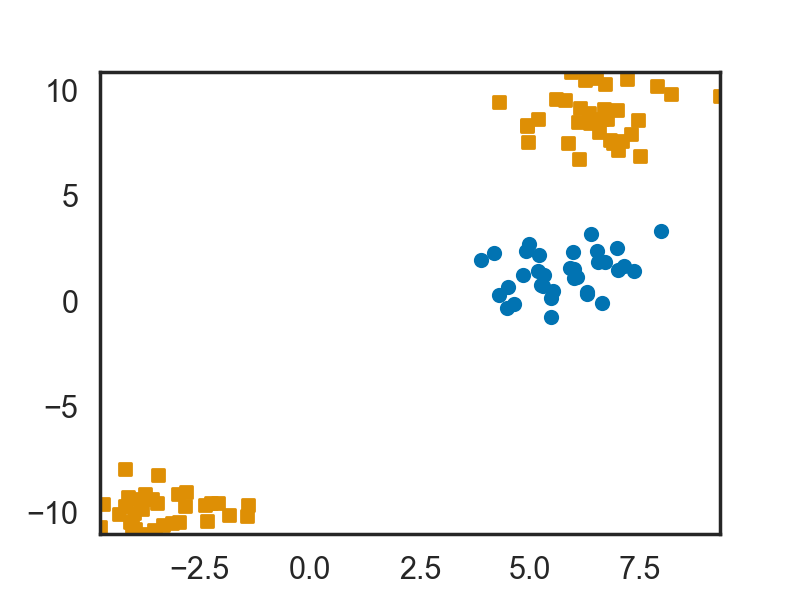

In [80]:
X, y, centers = make_blobs(n_samples=100, centers=3, n_features=2, return_centers = True)
y = [1 if x==2 else x for x in y] #Changing the class of the third blob so that there's only two classes.
plt.close()
plot_2d(X,y)
plt.show()

Clearly the separation is a circle (or rather an ovoid), very easy to imagine as a human, but what for a machine ? 

**9)** Use an SVM with a Gaussian kernel then a polynomial (with well-adapted parameters) then plot the decision boundaries of these algorithms on separate graphs.

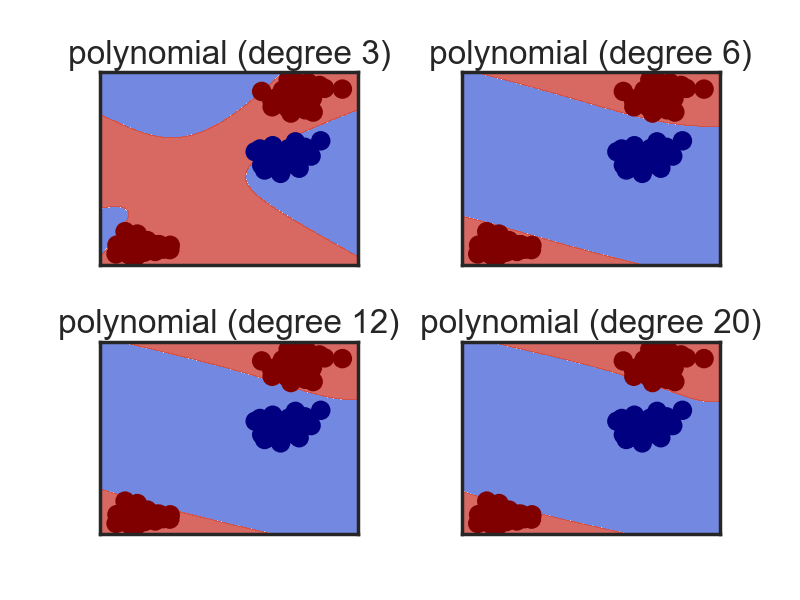

In [82]:
#Method found in the internet : 

plt.close('all')
h = .02  # step size in the mesh

#Fitting part
C = 1.0  # SVM regularization parameter
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
poly_svc2 = svm.SVC(kernel='poly', degree=6, C=C).fit(X, y)
poly_svc3 = svm.SVC(kernel='poly', degree=12, C=C).fit(X, y)
poly_svc4 = svm.SVC(kernel='poly', degree=20, C=C).fit(X, y)

#Mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ['polynomial (degree 3)',
          'polynomial (degree 6)',
          'polynomial (degree 12)',
          'polynomial (degree 20)']

#Plot
for i, clf in enumerate((poly_svc, poly_svc2, poly_svc3, poly_svc4)):
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.jet)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

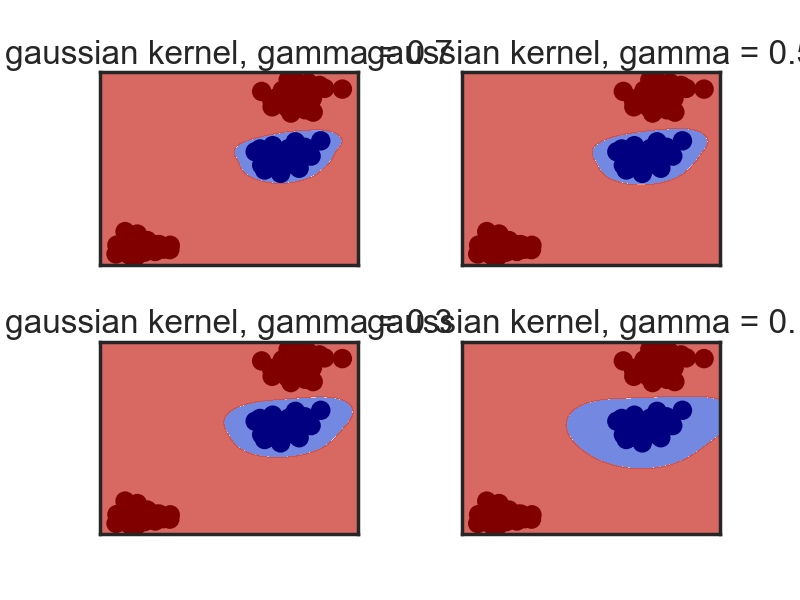

In [83]:
#Method found in the internet : 
plt.close('all')
h = .02  # step size in the mesh

#Fitting part
C = 1.0  # SVM regularization parameter
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
rbf_svc2 = svm.SVC(kernel='rbf', gamma = 0.5, C=C).fit(X, y)
rbf_svc3 = svm.SVC(kernel='rbf', gamma = 0.3, C=C).fit(X, y)
rbf_svc4 = svm.SVC(kernel='rbf', gamma = 0.1, C=C).fit(X, y)

#Mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ['gaussian kernel, gamma = 0.7',
          'gaussian kernel, gamma = 0.5',
          'gaussian kernel, gamma = 0.3',
          'gaussian kernel, gamma = 0.1']

#Plot
for i, clf in enumerate((rbf_svc, rbf_svc2, rbf_svc3, rbf_svc4)):
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.jet)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

Gaussian kernel does good, maybe delimits even too much in the first case, and for the polynomials, it gets better after degree 5 even if it's never perfect (some red dots end up in the blue zone). 

**10)** We wish to compare classification performance between different SVMs based on different kernels
(linear, polynomial and Gaussian). Propose a method allowing to compare these three algorithms.

We could try different parameters for each method (gamma list for rbf, degree list for poly), that's what I did above, but it doesn't really allow to compare **between** methods.
Another idea could be to see how each method does (with fixes hyperparameters) at varying C's. To see for instance if already at a very low C some method is better than others. That's what we do in 2 questions.</br>

The method I would still prefer is the following : How much training does a method require to perform good on given test data ? This is, after all, the goal of machine learning... and this is what we're implementing in the question 11 : which method has the best learning curve ?  

**11)** Draw the learning curve of the algorithm : with fixed hyper-parameters and fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

I will just start by explaining how I got my formula for the Bayes predictor : the Bayes classifier is written as follows
$$h_{Bayes}(x) = \mathbb{1}(\eta(x) \geq \dfrac{1}{2})$$
with 
$$\eta(x) = P(Y=1|X=x) =_{Bayes} \dfrac{P(X=x|Y=1)P(Y=1)}{P(X=x)} = \dfrac{f_1(x) \times 0.5}{P(X=x|Y=1)P(Y=1)+P(X=x|Y=-1)P(Y=-1)}$$
$$= \dfrac{f_1(x) \times 0.5}{f_1(x) \times 0.5+f_{-1}(x) \times 0.5} = \dfrac{f_1(x)}{f_1(x)+f_{-1}(x)} $$

In [84]:
mean1, mean2 = centers[0],centers[1]
cov1, cov2 = 1.0,1.0

def eta2(x):
    f_1      = multivariate_normal.pdf(x, mean=mean2, cov=cov1)
    f_minus1 = multivariate_normal.pdf(x, mean=mean1, cov=cov2)
    return f_1/(f_minus1 + f_1)

def bayesPred(X):
    if eta2(X) >= 0.5:
        return 1
    return 0

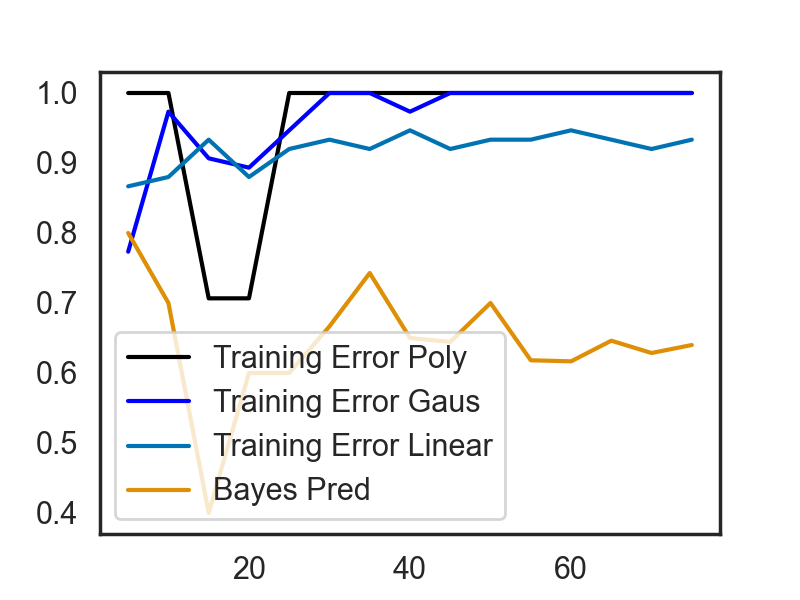

In [86]:
import random as rd

sizes = np.linspace(5,75,15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


#Hyperparameters
gamma = 0.5
degree = 6
C = 1.0
trainErrPoly, trainErrGaus, trainErrLin = [],[],[]
testErrPoly, testErrGaus, testErrLin = [],[],[]
bayesPredVal = []
for size in sizes:
    
    #Craft the random sub-set of random <size> data
    #I will shuffle at every iteration :
    randomize = np.arange(len(X_train))
    np.random.shuffle(randomize)
    for i in range(len(randomize)):
        randomize[i] = int(randomize[i])
        
    X_train = X_train[randomize]
    y_train = np.array(y_train)[randomize]
    X_rd, y_rd = X_train[:int(size)], y_train[:int(size)] 
    
    tmpBayes = 0
    #Bayes part
    
    #Model fit on this data for each model
    model_pol = svm.SVC(kernel='poly', degree=degree, C=C).fit(X_rd, y_rd)
    model_rbf = svm.SVC(kernel='rbf', gamma=gamma, C=C).fit(X_rd, y_rd)
    model_lin = svm.SVC(kernel='linear', C=C).fit(X_rd, y_rd)
    for i in range(len(X_rd)):
        if bayesPred(X_rd[i])==y_rd[i]:
            tmpBayes += 1
    trainErrPoly.append(model_pol.score(X_train, y_train))
    testErrPoly.append(model_pol.score(X_test, y_test))
    trainErrGaus.append(model_rbf.score(X_train, y_train))
    testErrGaus.append(model_rbf.score(X_test, y_test))
    trainErrLin.append(model_lin.score(X_train, y_train))
    testErrLin.append(model_lin.score(X_test, y_test))
    bayesPredVal.append(tmpBayes/size)
plt.close('all')

    
plt.plot(sizes, trainErrPoly, label = 'Training Error Poly', color='k')
#plt.plot(sizes, testErrPoly, label ='Test Error Poly', color='red')
plt.plot(sizes, trainErrGaus, label ='Training Error Gaus', color='blue')
#plt.plot(sizes, testErrGaus, label ='Test Error Gaus', color='green')
plt.plot(sizes, trainErrLin, label ='Training Error Linear')
#plt.plot(sizes, testErrLin, label ='Test Error Linear')
plt.plot(sizes, bayesPredVal, label ='Bayes Pred')

plt.legend()
plt.show() 

I will comment shortly on this one : Poly and Gaus learn both very fast, reaching their peak at a good rate (around 40, even though it bounces a little), while the linear one is lagging behind, and finally reaching a better peak towards the middle-end. But that peak is only at 0.9, 0.92, (it should be even lower, it's just that the problem is still somewhat a little linear, see solution below) because the linear model isn't suited at all to the problem. So it takes more time, to reach a lower peak, that was to be expected with the linear one for a non-linear solution. Actually the same could be said for the polynomial here, it is somewhat more suited to the problem than the gaussian one...
</br> Regarding the naïve Bayes classifier, we get poorer results (it might be because we made a mistake as well, but the prediction formula seems correct) but that was to be expected with, justement, the naive classifier. It takes more time to reach a much lower result. 

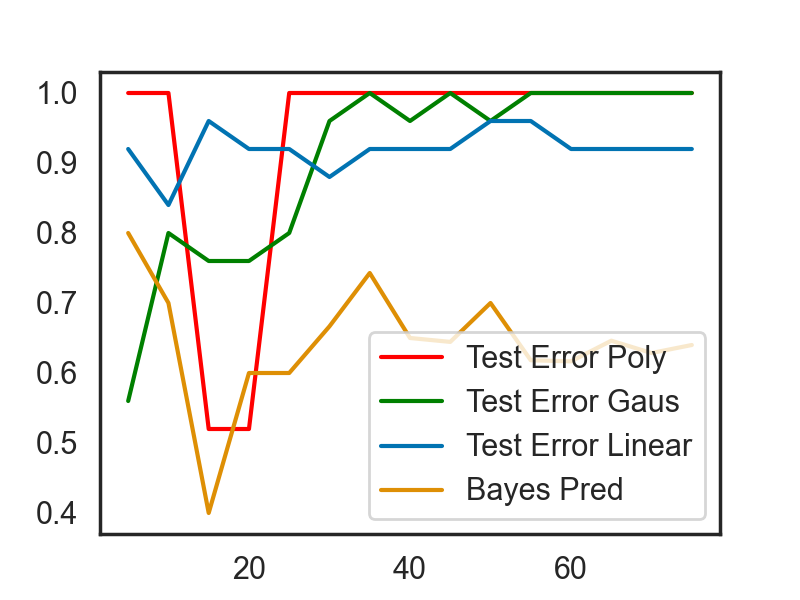

In [87]:
plt.close('all')
    
#plt.plot(sizes, trainErrPoly, label = 'Training Error Poly', color='k')
plt.plot(sizes, testErrPoly, label ='Test Error Poly', color='red')
#plt.plot(sizes, trainErrGaus, label ='Training Error Gaus', color='blue')
plt.plot(sizes, testErrGaus, label ='Test Error Gaus', color='green')
#plt.plot(sizes, trainErrLin, label ='Training Error Linear')
plt.plot(sizes, testErrLin, label ='Test Error Linear')
plt.plot(sizes, bayesPredVal, label ='Bayes Pred')

plt.legend()
plt.show()

We can say the same thing as before for the test error (i.e. we put our learning into practice), and I can also add something more : the gaussian model has a 100% accuracy even with data it never saw,same for the polynomial model **test** (we could have expected it to be a little bit worse than its **train** error, but the problem is well-suited to the polynomial method. Other data sets I worked with didn't yield the same results at all).
</br>(For example, this is what I wrote for another set : """This can be understood as polynomials don't fit as accurately the global problem as well, there's a "wrong-fitting" in this case""")
</br>
Regarding the Bayes estimator, it's a little naive, classifying only towards 60% good, but it was to be expected with a naive classifier. Something worth mentioning is that it still tends to the same results as the training data, so no overfitting. Neither for any of the other ones as well. 

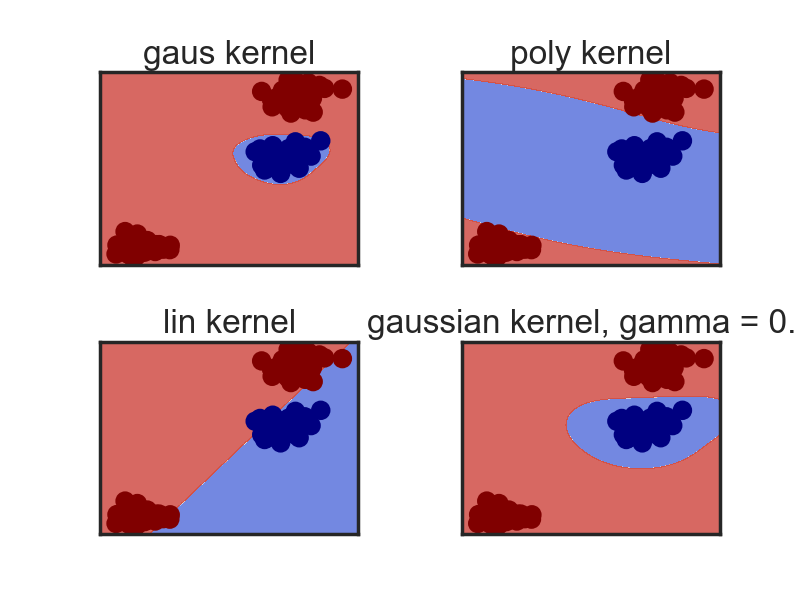

In [88]:
plt.close('all')
h = .02  # step size in the mesh

#Mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ['gaus kernel',
          'poly kernel',
          'lin kernel',
          'gaussian kernel, gamma = 0.1']

#Plot
for i, clf in enumerate((model_rbf, model_pol, model_lin, rbf_svc4)):
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.jet)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

I'm just printing above the frontiers so we can make sense of the various performances we saw on the graphs : the gaussian one is the only one with an actual true frontier separating blue from red with 100% accuracy (the only one with a 1.0 limit on the graphs), even though the polynomial frontier isn't bad (90% accuracy, we can see on these graphs the little red dots left on the wrong side). The linear one struggles more, but still gets OK results because of the configuration of the problem, with somewhat more blue points being on the top-left where there's also less red... It's more lucky than anything (with a centered gaussian + circle it would have had terrible results) but we still saw that it underperformed greatly compared to the other ones. I left the last one as a reference to how powerful gaussian kernels are. 

I could have taken a much worse problem like circle + gaussian in the middle to put the linear model out of the competition and give somewhat of an advantage to the gaussian one over the polynomial, but I think these graphs say already a lot (and I haven't had any luck with my blob rolls...)

**12)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.


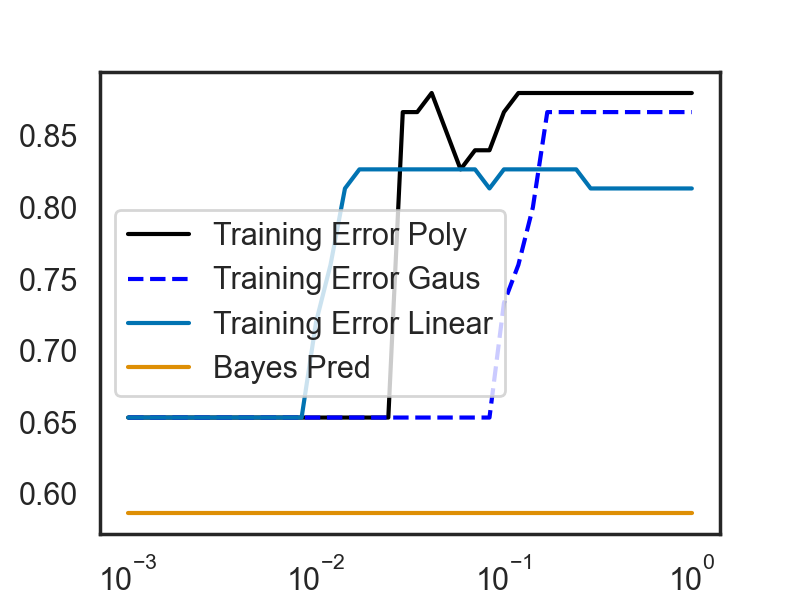

In [103]:
# Modify the class of some data points randomly

#I will modify 10 points of the 75 samples we have :
for i in range(10):
    y_train[5*i] = 1-y_train[5*i]
    #Method found in the internet : 

plt.close('all')
h = .02  # step size in the mesh
CL = np.logspace(-3,0,40)

#Hyperparameters
gamma = 0.5
degree = 6
trainErrPoly, trainErrGaus, trainErrLin = [],[],[]
testErrPoly, testErrGaus, testErrLin = [],[],[]
bayesPredVal = []
for Cvalue in CL:
    tmpBayes = 0    
    #Model fit on this data for each model
    model_pol = svm.SVC(kernel='poly', degree=degree, C=Cvalue).fit(X_rd, y_rd)
    model_rbf = svm.SVC(kernel='rbf', gamma=gamma, C=Cvalue).fit(X_rd, y_rd)
    model_lin = svm.SVC(kernel='linear', C=Cvalue).fit(X_rd, y_rd)
    for i in range(len(X_rd)):
        if bayesPred(X_rd[i])==y_rd[i]:
            tmpBayes += 1
    trainErrPoly.append(model_pol.score(X_train, y_train))
    testErrPoly.append(model_pol.score(X_test, y_test))
    trainErrGaus.append(model_rbf.score(X_train, y_train))
    testErrGaus.append(model_rbf.score(X_test, y_test))
    trainErrLin.append(model_lin.score(X_train, y_train))
    testErrLin.append(model_lin.score(X_test, y_test))
    bayesPredVal.append(tmpBayes/size)
plt.close('all')

    
plt.plot(CL, trainErrPoly, label = 'Training Error Poly', color='k')
#plt.plot(CL, testErrPoly, label ='Test Error Poly', color='red')
plt.plot(CL, trainErrGaus, label ='Training Error Gaus', color='blue', linestyle='dashed')
#plt.plot(CL, testErrGaus, label ='Test Error Gaus', color='green')
plt.plot(CL, trainErrLin, label ='Training Error Linear')
#plt.plot(CL, testErrLin, label ='Test Error Linear')
plt.plot(CL, bayesPredVal, label ='Bayes Pred')
plt.xscale('log')
plt.legend()
plt.show() 

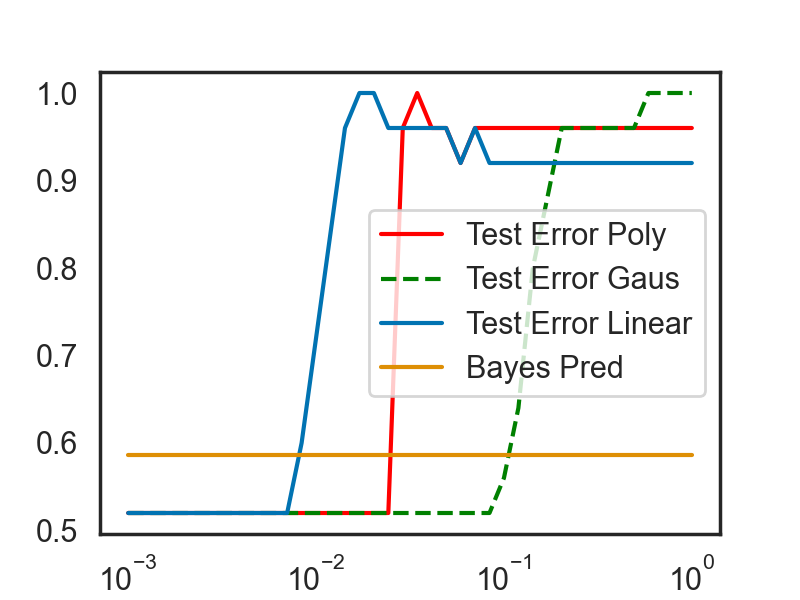

In [101]:
plt.close('all')

#plt.plot(CL, trainErrPoly, label = 'Training Error Poly', color='k')
plt.plot(CL, testErrPoly, label ='Test Error Poly', color='red')
#plt.plot(CL, trainErrGaus, label ='Training Error Gaus', color='blue')
plt.plot(CL, testErrGaus, label ='Test Error Gaus', color='green', linestyle='dashed')
#plt.plot(CL, trainErrLin, label ='Training Error Linear')
plt.plot(CL, testErrLin, label ='Test Error Linear')
plt.plot(CL, bayesPredVal, label ='Bayes Pred')
plt.xscale('log')

plt.legend()
plt.show() 

So, the first thing to notice is that the errors we introduced in the training set effectively reduced the accuracy below 1.0, and induced noise in the learning.
</br>
The main thing to understand if of course that pushing the complexity up has overall of positive effect on the results, we get closer to the training data and our results are supposedly more accurate. However, when there are mistakes in the training data, that leads to problems when applying the model to the test. Because we overfitted on WRONG data... So in that case we have to find a good C to compromise between accuracy and overfitting on data that's not relevant to all cases.
</br>

Another thing to notice is that the gaussian model doesn't yield the best of the best results in the training set, but even though there's this problem with the noisy labels, it is still the best (even though, again, it never sees the test data !) on the test data after we improve enough the complexity. It even reaches 100% even though it doesn't with the training set !
</br>
The polynomial model gives good results, but it more sensitive to noise, as we can see its accuracy goes down with complexity in the test set, even though it was at the highest score (0.88) on the training data. It kind of overfitted on wrong data, which led to problems in the test data, without noise. Same for the linear, which is only a degree 1 polynomial, it has worse results but it kind of behaves the same. 
</br>
I'll also say that the gaussian model needs more complexity to behave well, with $C = 0.1$ whereas the poly one only needed around $C=0.02$ to give satisfying results, even though in the end with $C=1$ the gaussian wins. 

A short remark on the Bayes values I found : of course it doesn't evolve with the complexity, as C doesn't even intervene. But worse than that, there isn't even a parameter in C, nothing to tweak to make it better, it is naive, there's no machine learning. This is why I didn't bother with specifically applying it to test or train data, I just took whatever was practical. We would have gotten roughly the same results, it's just a deterministic classifier, after all.

## SVM GUI THESE QUESTIONS HAVE BEEN ANSWERED SEPARATELY ON THE PDF INSIDE THE RAR

**13)** Start the script svm_gui.py available at the link : http://scikit-learn.org/stable/auto_
examples/applications/svm_gui.html
This application allows real-time evaluation of the impact the choice of the kernel and the regula-
rization parameter C.

**14)** Generate a very unbalanced data set with much more points in one class than in the other (at least
90% vs 10%)

**15)** Using a linear kernel and decreasing the parameter C what do you observe ?

## Going further : application to face classification

Code for downloading and organizing the data:

In [104]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**16)** By modifying the followind code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of C on a logarithmic scale between 1e5 and 1e-5.

Fitting the classifier to the training set


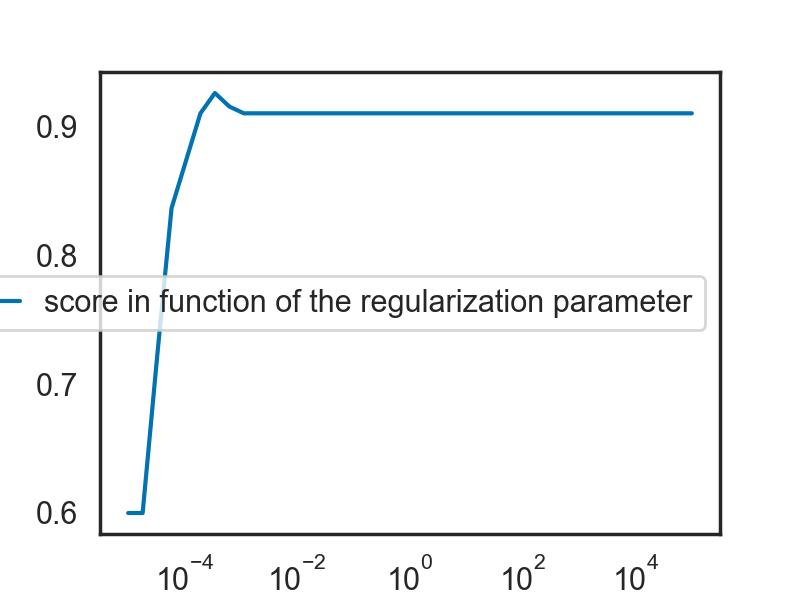

In [107]:
####################################################################
# Quantitative evaluation of the model quality on the test set
plt.close('all')
print("Fitting the classifier to the training set")
t0 = time()
scoreL = []
Cvaluez = np.logspace(-5,5,40) #I only took between 10^-3 and 1 previously because that was enough, but for here I'll follow the advice because more complexity is needed.
for Cva in Cvaluez:
    clf = svm.SVC(kernel="linear", C=Cva)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scoreL.append(score)
plt.plot(Cvaluez, scoreL, label = 'score in function of the regularization parameter')
plt.legend()
plt.xscale('log') 
plt.show()

As we saw before, the higher the regularization parameter, the better the result. After C reaches 1, it's no use pushing it up anymore, we're already at our peak performance. There's a peak at 10^-3 which might suggest overfitting for higher C values. 

In [108]:
print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.296s
Chance level : 0.6210526315789474
Accuracy : 0.9105263157894737


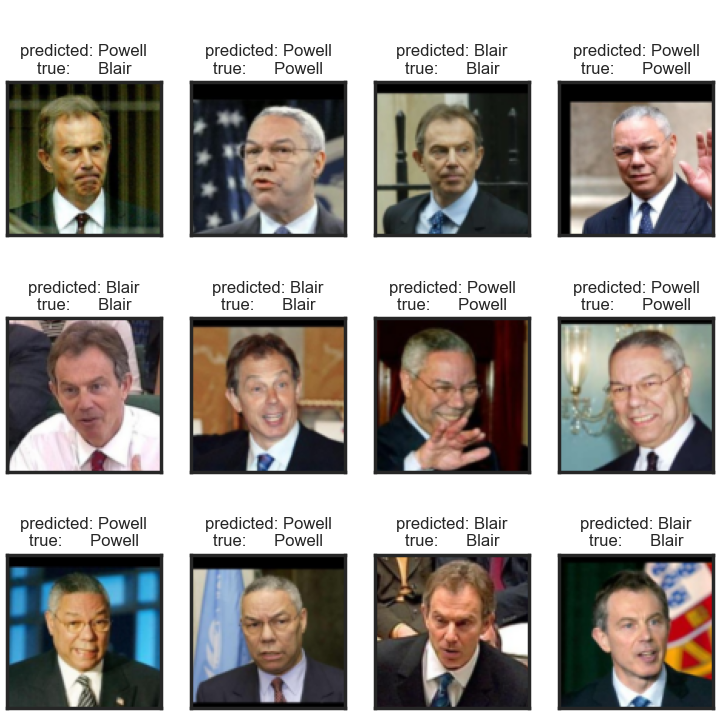

In [109]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

**17)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

In [115]:
# Nuisance variable adding
for i in range(20):
    y_train[8*i] = 1-y_train[8*i]

Fitting the classifier to the training set


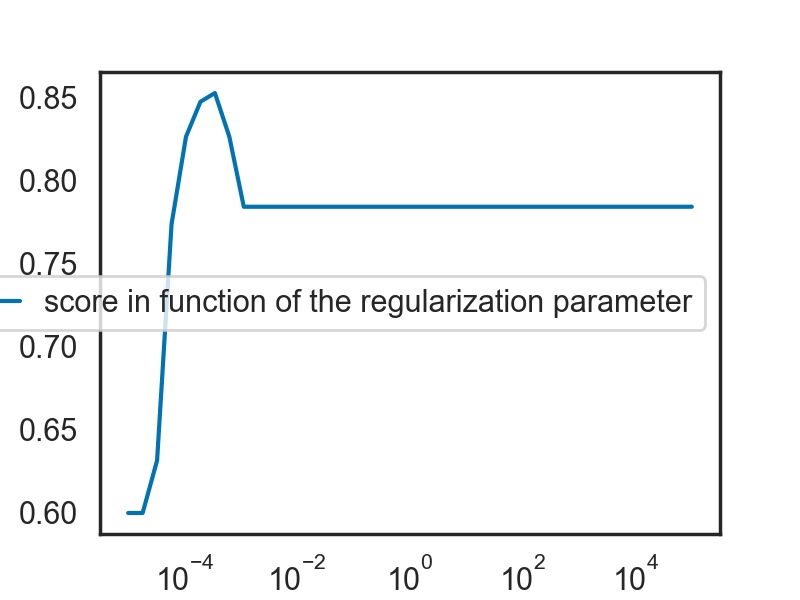

In [117]:
####################################################################
# Quantitative evaluation of the model quality on the test set
plt.close('all')
print("Fitting the classifier to the training set")
t0 = time()
scoreL = []
Cvaluez = np.logspace(-5,5,40) #I only took between 10^-3 and 1 previously because that was enough, but for here I'll follow the advice because more complexity is needed.
for Cva in Cvaluez:
    clf = svm.SVC(kernel="linear", C=Cva)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scoreL.append(score)
plt.plot(Cvaluez, scoreL, label = 'score in function of the regularization parameter')
plt.legend()
plt.xscale('log') 
plt.show()

In [118]:
print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.501s
Chance level : 0.6210526315789474
Accuracy : 0.7842105263157895


Clearly, after a first "noisification", performance dropped. Accuracy fell in the last call to clf.predict, and clearly the scores aren't as high as before in the C graph. I'll do it again to be sure :

In [119]:
# Nuisance variable adding
for i in range(20):
    y_train[7*i] = 1-y_train[7*i]

Fitting the classifier to the training set


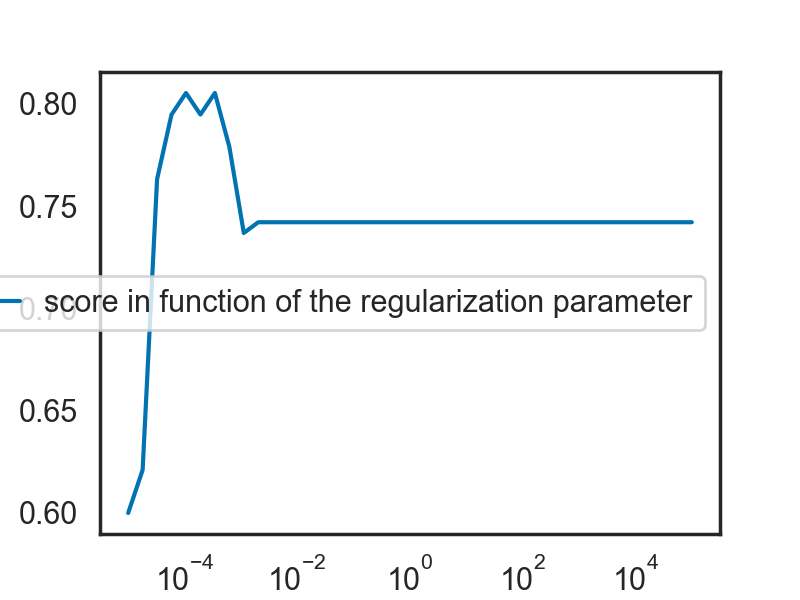

In [120]:
####################################################################
# Quantitative evaluation of the model quality on the test set
plt.close('all')
print("Fitting the classifier to the training set")
t0 = time()
scoreL = []
Cvaluez = np.logspace(-5,5,40) #I only took between 10^-3 and 1 previously because that was enough, but for here I'll follow the advice because more complexity is needed.
for Cva in Cvaluez:
    clf = svm.SVC(kernel="linear", C=Cva)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scoreL.append(score)
plt.plot(Cvaluez, scoreL, label = 'score in function of the regularization parameter')
plt.legend()
plt.xscale('log') 
plt.show()

In [122]:
print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.416s
Chance level : 0.6210526315789474
Accuracy : 0.7421052631578947


Clearly, adding noise reduces performances.

**18)** Explain why the features are centered and reduced.



**19)** What is the effect of choosing a non-linear RBF kernel on prediction? You will be able to improve the prediction with a reduction of dimension based on the object sklearn.decomposition.RandomizedPCA.

Features are centered and reduced so it makes sense to compare them.

Non linear RBF kernels tend to work better than linear ones (they can be linear if needed, but also non-linear), and they're more resistant to errors in the training data.

In [ ]:
Guillaume, Baptiste